<a href="https://colab.research.google.com/github/mett29/DL-Competition/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0.0

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
#!rm -r DL-CompetitionsDatasets/

In [0]:
# This permits to let colab work without having to stay online
# You can let colab save the model by itself when it ends
from google.colab import drive
googleDrivePath = 'drive'
drive.mount('/content/'+googleDrivePath)

In [1]:
from getpass import getpass
import os

user = getpass('Github user')
password = getpass('Github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

#!git clone https://$GITHUB_AUTH@github.com/mett29/DL-Competition.git
#!git submodule update --init --recursive
!git clone https://$GITHUB_AUTH@github.com/DanieleParravicini/DL-CompetitionsDatasets

Github user··········
Github password··········
Cloning into 'DL-CompetitionsDatasets'...
remote: Enumerating objects: 2079, done.
remote: Total 2079 (delta 0), reused 0 (delta 0), pack-reused 2079
Receiving objects: 100% (2079/2079), 90.16 MiB | 39.88 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (106 kB/s)
Selecting previously unselected package tree.
(Reading database ... 134923 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [5]:
PATH = "DL-CompetitionsDatasets/Classification_Dataset"
!tree DL-CompetitionsDatasets/Classification_Dataset/ -d

/bin/bash: tree: command not found


In [0]:
SEED = 1234
tf.random.set_seed(SEED)

In [0]:
def augment_images(folder):
  for dirname in os.listdir(folder):
    for filename in os.listdir(os.path.join(folder,dirname)):
      dir_path = os.path.join(folder, dirname)

      # Read the image
      img = cv2.imread(os.path.join(dir_path, filename))

      # Apply augmentation
      horizontal_flip = cv2.flip(img, 0)
      vertical_flip = cv2.flip(img, 1)
      matrix = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), -30, 1)
      rotated = cv2.warpAffine(img, matrix, (img.shape[1], img.shape[0]))
      blur = cv2.GaussianBlur(img, (55,55), 0)

      # Save into the same dir the augmented images
      cv2.imwrite(os.path.join(dir_path, str('aug_flip_hor_' + filename)), horizontal_flip)
      cv2.imwrite(os.path.join(dir_path, str('aug_flip_vert_' + filename)), vertical_flip)
      cv2.imwrite(os.path.join(dir_path, str('aug_rotated_' + filename)), rotated)
      cv2.imwrite(os.path.join(dir_path, str('aug_blur_' + filename)), blur)

In [0]:
#augment_images("DL-CompetitionsDatasets/Classification_Dataset/training")

In [0]:
#!rm DL-CompetitionsDatasets/Classification_Dataset/training/*/aug*.jpg

In [0]:
apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(zoom_range=0.1,
                                        rotation_range=10,
                                        horizontal_flip=True,
                                        vertical_flip=False,  
                                        fill_mode='nearest',                             
                                        rescale=1./255,
                                        validation_split=0.1)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255,
                                        fill_mode='nearest',
                                        cval=0,
                                        validation_split=0.1)

# Create test ImageDataGenerator objects
test_data_gen = ImageDataGenerator(rescale=1./255)

In [54]:
batch_size = 64
no_epochs = 50
no_classes = 20

IMG_HEIGHT = 64
IMG_WIDTH = 64

decide_class_indices = True
if decide_class_indices:
    classes = ['owl',                   # 0
               'galaxy',                # 1
               'lightning',             # 2
               'wine-bottle',           # 3
               't-shirt',               # 4
               'waterfall',             # 5
               'sword',                 # 6
               'school-bus',            # 7
               'calculator',            # 8
               'sheet-music',           # 9
               'airplanes',             # 10
               'lightbulb',             # 11
               'skyscraper',            # 12
               'mountain-bike',         # 13
               'fireworks',             # 14
               'computer-monitor',      # 15
               'bear',                  # 16
               'grand-piano',           # 17
               'kangaroo',              # 18
               'laptop']                # 19
else:
    classes=None

dataset_dir = os.path.join(PATH, 'training')

train_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               batch_size=batch_size,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training',
                                               seed=SEED)

# Validation
valid_gen = train_data_gen.flow_from_directory(dataset_dir,
                                               batch_size=batch_size, 
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation',
                                               seed=SEED)

Found 1406 images belonging to 20 classes.
Found 148 images belonging to 20 classes.


In [0]:
# This function will plot images in the form of a grid with 1 row and 4 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# train_gen.class_indices

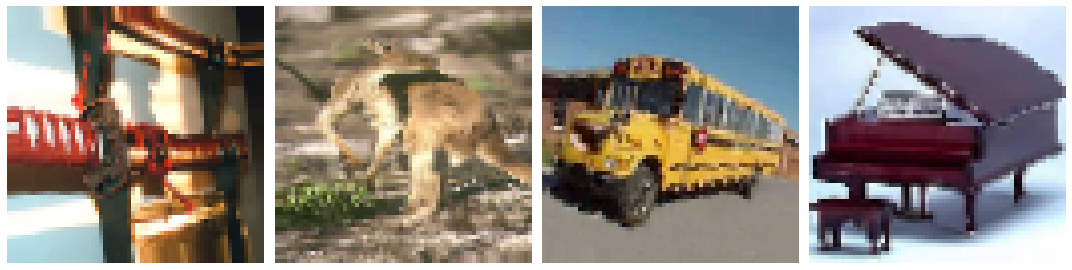

In [56]:
sample_training_images, _ = next(train_gen)
plotImages(sample_training_images[:4])

In [0]:
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, no_classes]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, 3], [None, no_classes]))

valid_dataset = valid_dataset.repeat()

In [0]:
def get_model():

  model = Sequential([               
      Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
      MaxPooling2D(),

      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),

      Conv2D(128, 3, padding='same', activation='relu'),
      MaxPooling2D(),

      Conv2D(256, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Dropout(0.4),

      Flatten(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      Dense(20, activation='softmax')
  ])

  return model

In [113]:
model = get_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 8, 8, 128)       

In [0]:
# Optimization parameters
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = ['accuracy']

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [0]:
from datetime import datetime

# Callbacks

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Early stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
    callbacks.append(es_callback)

In [0]:
import shutil 

max_image_count = 0
count_files = []
training_path = PATH + '/training'

for dir in classes:
    basepath = training_path + '/' + dir;
    files = [f for f in os.listdir(basepath) if os.path.isfile(basepath + "/" + f)]
    count_files.append(len(files))
    #print('files under ', dir,':', count_files[-1])
    if(count_files[-1] > max_image_count):
      max_image_count = count_files[-1];

#print('current max', max_image_count)
inverse_representativity_of_the_class = list( map(lambda x: x/max_image_count, count_files))
#print(inverse_representativity_of_the_class)

In [117]:
class_weight = {}
for i, w in enumerate(inverse_representativity_of_the_class):
  class_weight[str(i)] = w

history = model.fit(x=train_dataset,
          epochs=no_epochs,
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=callbacks,
          #class_weight=class_weight
         )

model.save_weights(str(datetime.now().strftime('%b%d_%H-%M')) + "_try.h5")

Train for 22 steps, validate for 3 steps
Epoch 1/50
22/22 [==============================] - 9s 412ms/step - loss: 2.9894 - accuracy: 0.0619 - val_loss: 2.9671 - val_accuracy: 0.0676
Epoch 2/50
22/22 [==============================] - 8s 381ms/step - loss: 2.9428 - accuracy: 0.0711 - val_loss: 2.8869 - val_accuracy: 0.1081
Epoch 3/50
22/22 [==============================] - 8s 360ms/step - loss: 2.8789 - accuracy: 0.1046 - val_loss: 2.8215 - val_accuracy: 0.1486
Epoch 4/50
22/22 [==============================] - 8s 372ms/step - loss: 2.7278 - accuracy: 0.1387 - val_loss: 2.5573 - val_accuracy: 0.2162
Epoch 5/50
22/22 [==============================] - 8s 369ms/step - loss: 2.5254 - accuracy: 0.2084 - val_loss: 2.3542 - val_accuracy: 0.2838
Epoch 6/50
22/22 [==============================] - 8s 375ms/step - loss: 2.4133 - accuracy: 0.2418 - val_loss: 2.2408 - val_accuracy: 0.3378
Epoch 7/50
22/22 [==============================] - 8s 371ms/step - loss: 2.3091 - accuracy: 0.2838 - val_l

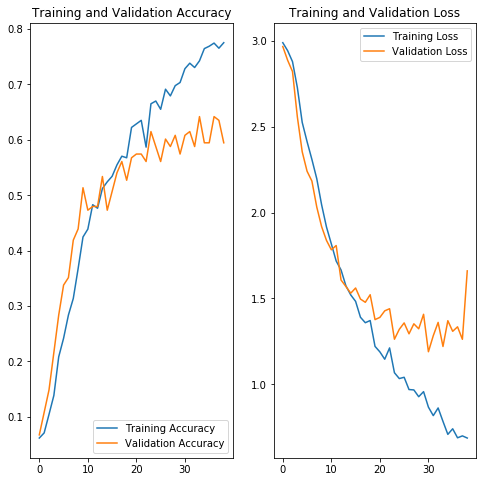

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(39)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [0]:
# load a single image
img_path = 'kangaroo.jpg'
new_image = load_image(img_path)

# check prediction
pred = model.predict_classes(new_image, batch_size=64)

In [0]:
print(pred)

[7]


In [0]:
image_filenames = next(os.walk('DL-CompetitionsDatasets/Classification_Dataset/test'))[2]

results = {}
for image_name in image_filenames:

  img = image.load_img(os.path.join('DL-CompetitionsDatasets/Classification_Dataset/test/', image_name), target_size=(IMG_HEIGHT, IMG_WIDTH))
  img_tensor = image.img_to_array(img)                    
  img_tensor = np.expand_dims(img_tensor, axis=0)         
  img_tensor /= 255. 

  prediction = model.predict_classes(img_tensor, batch_size=64)
  results[image_name] = prediction[0]

In [67]:
results

{'IMG_0.jpg': 8,
 'IMG_1001.jpg': 5,
 'IMG_1007.jpg': 14,
 'IMG_1011.jpg': 19,
 'IMG_1023.jpg': 0,
 'IMG_1031.jpg': 14,
 'IMG_1035.jpg': 13,
 'IMG_1037.jpg': 7,
 'IMG_104.jpg': 12,
 'IMG_1042.jpg': 0,
 'IMG_1046.jpg': 17,
 'IMG_105.jpg': 7,
 'IMG_1050.jpg': 0,
 'IMG_1052.jpg': 19,
 'IMG_1058.jpg': 17,
 'IMG_1059.jpg': 5,
 'IMG_106.jpg': 9,
 'IMG_1071.jpg': 0,
 'IMG_1072.jpg': 14,
 'IMG_1073.jpg': 7,
 'IMG_1074.jpg': 7,
 'IMG_1080.jpg': 3,
 'IMG_1084.jpg': 12,
 'IMG_1090.jpg': 12,
 'IMG_1094.jpg': 7,
 'IMG_1097.jpg': 17,
 'IMG_1099.jpg': 11,
 'IMG_1101.jpg': 7,
 'IMG_1117.jpg': 10,
 'IMG_1119.jpg': 9,
 'IMG_1127.jpg': 7,
 'IMG_113.jpg': 15,
 'IMG_1133.jpg': 0,
 'IMG_1137.jpg': 14,
 'IMG_1143.jpg': 4,
 'IMG_1147.jpg': 3,
 'IMG_1148.jpg': 0,
 'IMG_1155.jpg': 8,
 'IMG_1158.jpg': 13,
 'IMG_1163.jpg': 14,
 'IMG_117.jpg': 0,
 'IMG_1172.jpg': 15,
 'IMG_1174.jpg': 8,
 'IMG_1179.jpg': 7,
 'IMG_1183.jpg': 17,
 'IMG_1187.jpg': 12,
 'IMG_119.jpg': 9,
 'IMG_1194.jpg': 8,
 'IMG_1196.jpg': 1,
 'IMG_11

In [0]:
import cv2
from google.colab.patches import cv2_imshow

path = "DL-CompetitionsDatasets/Classification_Dataset/test"

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
      img = cv2.imread(os.path.join(folder,filename))
      if img is not None:
          images.append(img)
    return images

images = load_images_from_folder(path)

for i, img in enumerate(images):
  cv2_imshow(img)
  print(list(results.items())[i])

In [0]:
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [0]:
create_csv(results)

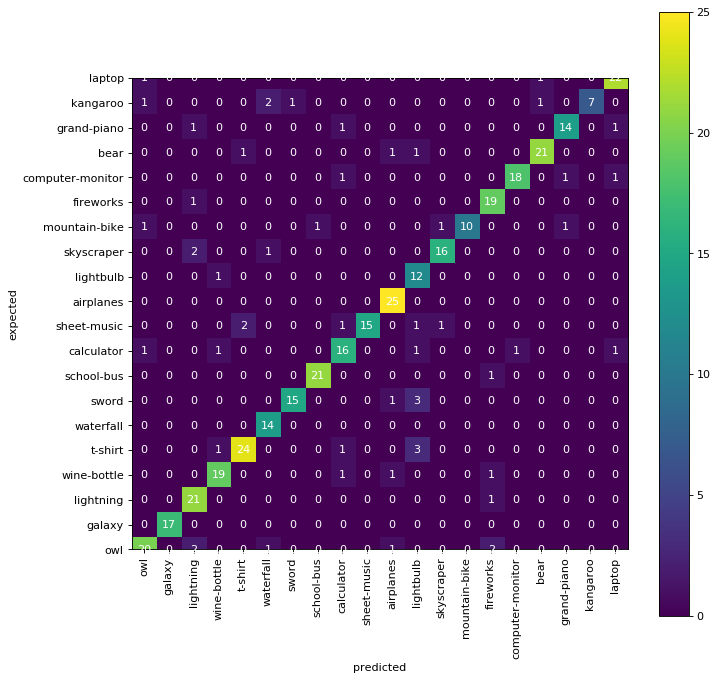

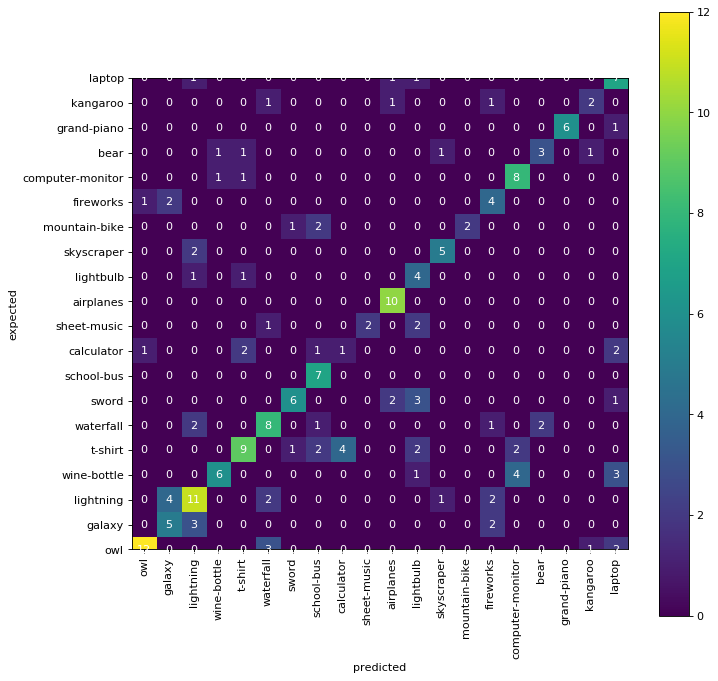

In [120]:
def computeConfusion(dataset, max_num ):
  confusion_matrix = [[ 0 for i in range(0,len(classes))] for i in range(0,len(classes))];

  it = iter(dataset)
  i = 0;
  while( i < max_num):
    batch = next(it)
    images = batch[0]
    labels = batch[1]
    for j,l in enumerate(labels):
      
      if(i > max_num):
        break;

      res = model.predict( tf.expand_dims(images[j], 0))
      expected = np.argmax(l)
      predicted = np.argmax(res);
      '''
      print(l, expected, res, predicted)
      plt.figure()
      plt.subplot(1, 3,1)
      plt.barh(classes,l)
      plt.subplot(1,3,2)
      plt.barh(classes,res[0])
      plt.subplot(1,3,3)
      plt.imshow(images[j])
      plt.show()
      print(expected, predicted)'''
      confusion_matrix[expected][predicted] +=1
      i+=1

  plotConfusionMatrix(confusion_matrix);
      
def plotConfusionMatrix(conf):
  plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
  im = plt.imshow(conf)
  plt.yticks(range(0,20), labels=classes);
  plt.xticks(range(0,20), labels=classes, rotation='vertical' );
  plt.ylabel("expected");
  plt.xlabel("predicted");
  plt.gca().invert_yaxis()
  plt.colorbar();

  for y in range(len(conf)):
      for x in range(len(conf[y])):
          plt.text(x, y , '{:.0f}'.format(conf[y][x]),
                  color='w',horizontalalignment='center',
                  verticalalignment='center')


computeConfusion(train_dataset, 400);
computeConfusion(valid_dataset, 200);

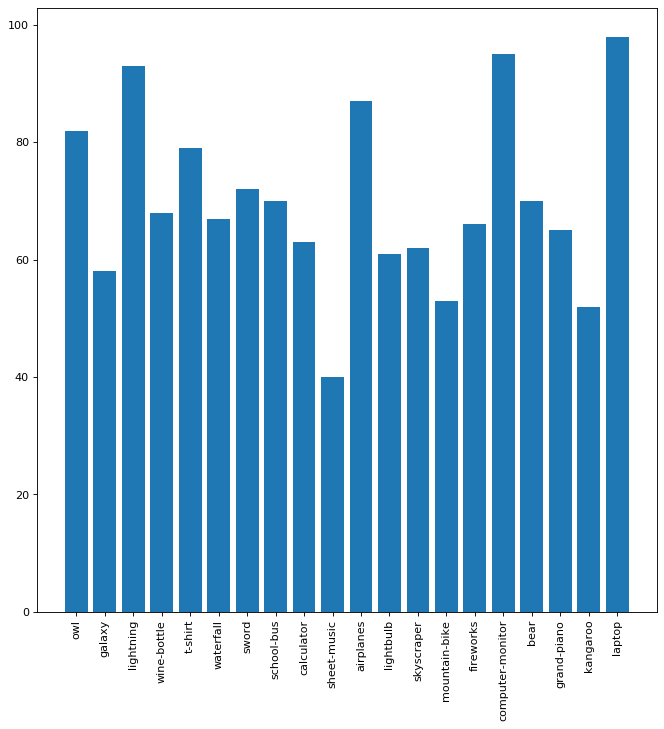

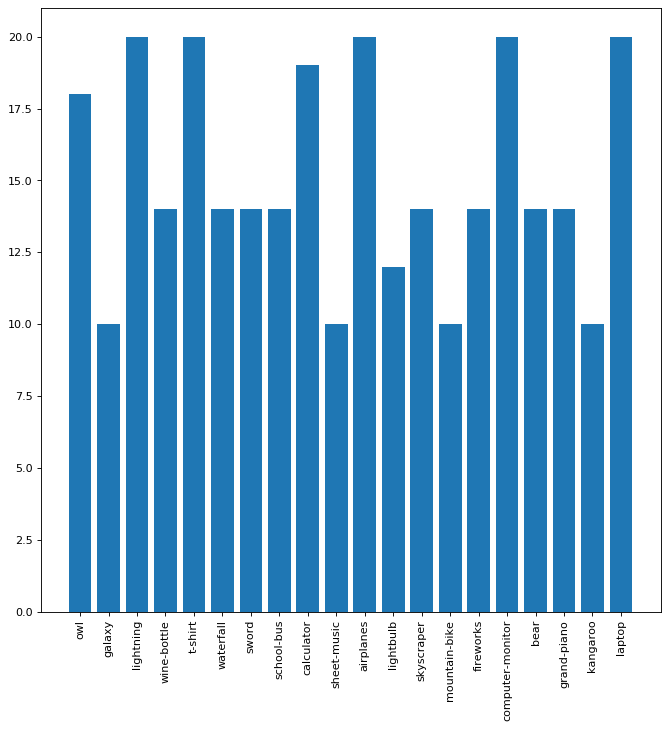

In [121]:
def plotDatasetDistribution(dataset, max_num ):
  classes_count = [0 for i in range(len(classes))]

  it = iter(dataset)
  i = 0;
  while( i < max_num):
    batch = next(it)
    labels = batch[1]
    for l in labels:
      if(i > max_num):
        break
      expected = np.argmax(l)
      classes_count[expected]+=1
      i+=1
  #print(classes_count)
  plt.figure( figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k');
  plt.bar(range(len(classes)), classes_count )
  plt.xticks( ticks=range(len(classes)) ,labels=classes, rotation='vertical' )
  plt.show()

plotDatasetDistribution(train_dataset, 1400)
plotDatasetDistribution(valid_dataset, 300)